### Retrieval-Augmented Generation (RAG) - Query Translation -  RAG Fusion
**Problem:** User queries are challenging. If user provides an ambiguous query, they will get ambiguous matches. 
             LLMs just follow what was in the context and produce the results as it is.

**Solution:** There are multiple ways to tackle the above problem.

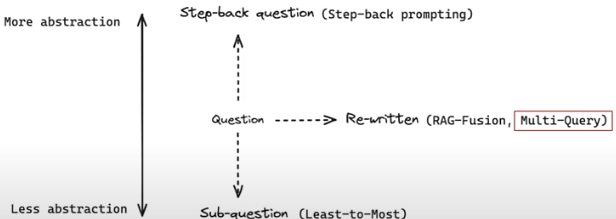
             
- More Abstraction: Refers to generalizing or stepping back to view the question from a higher-level perspective.
  - Example: Instead of directly asking for a specific answer, you might frame a question like, "What broader concepts should I consider for this problem?"
- Less Abstraction: Refers to breaking the question into specific, granular sub-questions that are easier to answer..
  - Example: For the question, "How does climate change affect agriculture?" sub-questions might be:
    - "What is climate change?"
    - "What are the main impacts of climate change on crop growth?"
- Rewriting the query using RAG-Fusion or Multi-Query
  - **RAG-Fusion**: Combining retrieved documents or information from multiple sources to provide a more comprehensive context.
  - **Multi-Query**: Generating multiple variations of the question to improve the chances of retrieving relevant information.

This section discusses on **RAG Fusion**, a Query Translation in RAG.

##### Key Highlights:
- **Implement Multi-Query Translation**
  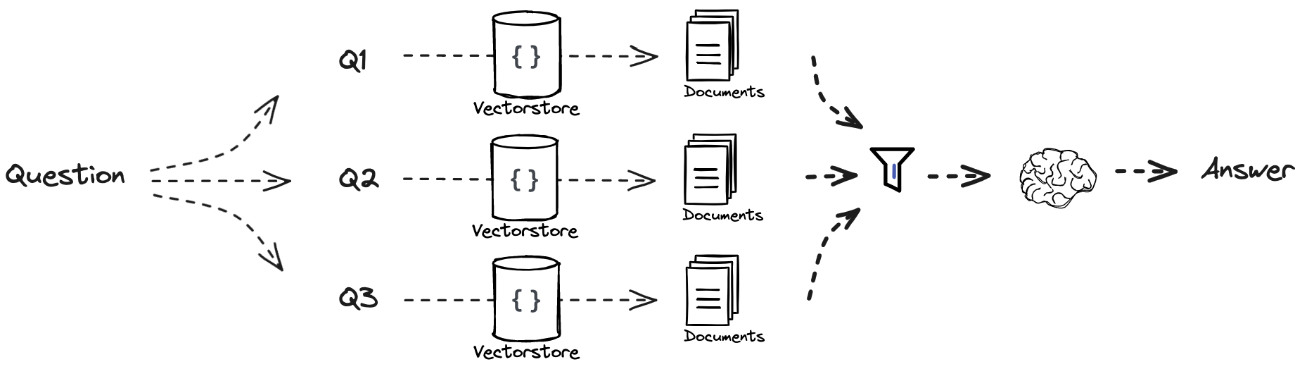
  - The question is broke into multiple questions based on different perspectives. This increases the likelihood of retrieving relevant information from the vector store.
  - Each question is sent to the retriever and fetches the relevant chunk from the vector store.
  - Ranking is performed on all retrieved documents for a query. Similarly ranking is estimated for all queries. Reciprocal Rank Fusion (RRF) score is estimated for every chunk retrieved.
  - RRF prioritizes documents that appear higher across multiple ranked lists, ensuring relevance without bias toward any single retriever.
    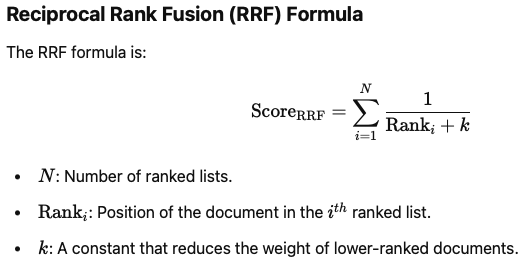
    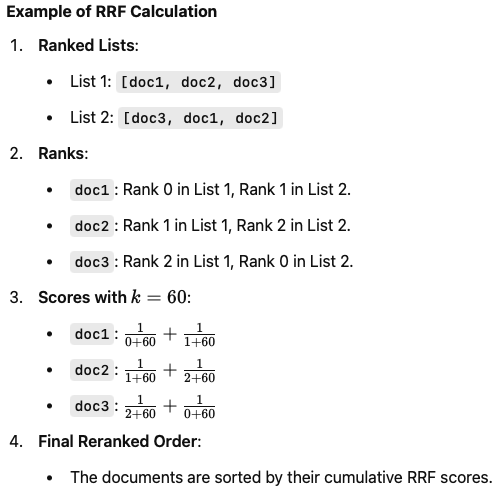
  

##### What's Next: 


#### Install required libraries

In [2]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [3]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
import numpy as np
from langchain.load import dumps, loads
from operator import itemgetter

#### Environment Setup

In [4]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### RAG Process

##### Load, Split, Index

In [5]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents based on tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB

## Retrieve the documents that are closing matching with prompt using KNN
retriever = vectorstore.as_retriever(search_kwargs={"k": 5}) 

#### **Prompt - Generate multiple queries**
Write a Prompt in such a way that the query is converted into multiple queries utilizing the capability of LLM model

In [6]:
# RAG Fusion Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

generate_queries

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are a helpful assistant that generates multiple search queries based on a single input query. \n\nGenerate multiple search queries related to: {question} \n\nOutput (4 queries):'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x157f438d0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x144931590>, root_client=<openai.OpenAI object at 0x15742fb90>, root_async_client=<openai.AsyncOpenAI object at 0x157fb1d10>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))
| StrOutputParser()
| RunnableLambda(...)

#### **Estiamte the Reciprocal Rank Fusion (RRF) score of retrieved chunks**

The Reciprocal Rank Fusion (RRF) score is estimated for all the chunks and the RRF score is used in the chain.

In [12]:
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

question = "What is task decomposition for LLM agents?"
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

8

#### LLM, Invoke

In [14]:
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# Define LLM
llm = ChatOpenAI(temperature=0)

final_rag_fusion_chain = (
    {"context": retrieval_chain_rag_fusion, "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

# Invoke LLM
final_rag_fusion_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This process enables the agent to efficiently handle complex tasks by dividing them into multiple manageable tasks, making it easier for the agent to navigate through the problem-solving process. Task decomposition can be achieved through various methods such as prompting the LLM with simple instructions, using task-specific instructions, or incorporating human inputs.'

**Few Takeaways:**

Why RAG Fusion?
- Flexibility in Retrieval Settings: RAG Fusion allows customization based on the system's needs:
    - Use different retriever architectures (e.g., dense vs. sparse).
    - Adjust fusion weights or algorithms (e.g., RRF, majority voting).
- Increased Robustness: If one retriever fails (e.g., due to poor performance on a specific query type), the fusion process ensures that other retrievers can compensate for its shortcomings. This leads to a more resilient system overall.
- Improved Relevance of Results: Fusion ensures that documents retrieved using different retrieval strategies are blended.
    - For instance:
        - One retriever might focus on semantic similarity (vector-based).
        - Another might focus on exact match or keyword frequency (keyword-based).
    - Combining them increases the likelihood of including the most relevant documents.